# 数据说明
预选赛训练数据和区域赛训练数据分别为不同10个风电场近一年的运行数据共30万余条，每15分钟采集一次，包括风速、风向、温度、湿度、气压和真实功率等，具体的数据字段中英文对应如下：

- WINDSPEED 预测风速
- WINDDIRECTION 风向
- TEMPERATURE 温度
- HUMIDITY 湿度
- PRESSURE 气压
- ROUND(A.WS,1) 实际风速
- ROUND(A.POWER,0) 实际功率

考虑到风电场的特殊性，不同风机间的地理位置也是序列预测的一个重要参考价值。不过本文更关注于与该项目类似的场景，多时间序列预测其实在各个企业里非常常见，比如生产企业不同电机的工况、不同产品在不同地区的销量预测，如果关联性不是特别大的情况，我们可以考虑用纯时间序列预测生成基线结果。


In [8]:
#导入需要的包
%matplotlib inline
import os
import shutil # 文件和目录操作
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
import paddlets
from paddlets import TSDataset
from paddlets import TimeSeries
from paddlets.models.forecasting import MLPRegressor, LSTNetRegressor
from paddlets.transform import Fill, StandardScaler
from paddlets.metrics import MSE, MAE
from paddlets.analysis import AnalysisReport, Summary
from paddlets.datasets.repository import get_dataset
import warnings
warnings.filterwarnings('ignore')

### 04-1.csv 和 04-2.csv是同一个风机多次导出的数据，需要合并
### 有.csv也有.xlsx，需要统一格式

In [13]:
def data_preprocess(src_data_dir, dst_data_dir):
    files = os.listdir(src_data_dir)
    # 第一步，完成数据格式统一
    for f in files:
        # 获取文件路径
        data_file = os.path.join(src_data_dir, f)
        # 获取文件名后缀
        data_type = os.path.splitext(data_file)[-1]
        # 获取目标文件名
        data_file_dst = os.path.join(dst_data_dir, f)
        data_name = os.path.splitext(data_file_dst)[0]
        # 如果是excel文件，进行转换
        if data_type == '.xlsx':
            # 需要特别注意的是，在读取excel文件时要指定空值的显示方式，否则会在保存时以字符“.”代替，影响后续的数据分析
            data_xls = pd.read_excel(data_file, index_col=0, na_values='')
            # 将csv文件存到目标目录
            data_xls.to_csv(data_name + '.csv', encoding='utf-8')
        else:
            # 将csv文件存到目标目录
            shutil.copy(data_file, dst_data_dir)

    # 第二步，完成多文件的合并，文件目录要重新更新一次
    files = os.listdir(dst_data_dir)
    for f in files:
        # 获取文件路径
        data_file = os.path.join(dst_data_dir, f)
        # 获取文件名前缀
        data_basename = os.path.basename(data_file)
        # 检查风机数据是否有多个数据文件
        if len(data_basename.split('-')) > 1:
            merge_list = []
            # 找出该风机的所有数据文件
            matches = [ f for f in files if (f.find(data_basename.split('-')[0] + '-') > -1)]
            for i in matches:
                # 读取风机这部分数据
                data_df = pd.read_csv(os.path.join(dst_data_dir, i), index_col=False, keep_default_na=False)
                merge_list.append(data_df)
            if len(merge_list) > 0:
                all_data = pd.concat(merge_list,axis=0,ignore_index=True).fillna(".")
                all_data.to_csv(os.path.join(dst_data_dir, data_basename.split('-')[0]+ '.csv'),index=False) 
            for i in matches:
                # 删除这部分数据文件
                os.remove(os.path.join(dst_data_dir, i))
            # 更新文件目录
            files = os.listdir(dst_data_dir)


In [14]:
data_preprocess(src_data_dir='../../data/raw/wind-power-forecast',
                 dst_data_dir='../../data/processed/wind-power-forecast')

# 数据EDA

In [16]:
# 读取一份数据文件，这里需要特别注意时间戳字段的格式指定
df = pd.read_csv('../../data/processed/wind-power-forecast/04.csv',parse_dates=['DATATIME'],infer_datetime_format=True,dayfirst=True)

# 查看04号风机的运行工况数据
df.head()

,DATATIME,WINDSPEED,PREPOWER,WINDDIRECTION,TEMPERATURE,HUMIDITY,PRESSURE,"ROUND(A.WS,1)","ROUND(A.POWER,0)",YD15
0,2021-01-02 00:00:00,7.5,17875.0,5,4.2,59,1023,4.3,3957.0,3896.0
1,2021-01-02 00:15:00,7.5,17892.0,5,4.2,59,1023,4.5,4788.0,4715.0
2,2021-01-02 00:30:00,7.5,17887.0,5,4.2,58,1023,4.3,5536.0,5929.0
3,2021-01-02 00:45:00,7.5,17882.0,4,4.1,57,1022,3.6,4509.0,5668.0
4,2021-01-02 01:00:00,7.5,17877.0,4,4.1,56,1022,3.4,4695.0,5125.0


# 用paddlets完成初步数据分析

In [17]:
df.columns

Index(['DATATIME', 'WINDSPEED', 'PREPOWER', 'WINDDIRECTION', 'TEMPERATURE',
       'HUMIDITY', 'PRESSURE', 'ROUND(A.WS,1)', 'ROUND(A.POWER,0)', 'YD15'],
      dtype='object')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89868 entries, 0 to 89867
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATATIME          89868 non-null  datetime64[ns]
 1   WINDSPEED         89868 non-null  float64       
 2   PREPOWER          89868 non-null  float64       
 3   WINDDIRECTION     89868 non-null  int64         
 4   TEMPERATURE       89868 non-null  float64       
 5   HUMIDITY          89868 non-null  int64         
 6   PRESSURE          89868 non-null  int64         
 7   ROUND(A.WS,1)     89349 non-null  float64       
 8   ROUND(A.POWER,0)  89349 non-null  float64       
 9   YD15              89552 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 6.9 MB


In [19]:
df.tail()

,DATATIME,WINDSPEED,PREPOWER,WINDDIRECTION,TEMPERATURE,HUMIDITY,PRESSURE,"ROUND(A.WS,1)","ROUND(A.POWER,0)",YD15
89863,2022-07-31 22:45:00,3.2,2212.6,226,28.0,92,1002,NaN,NaN,NaN
89864,2022-07-31 23:00:00,3.2,2230.8,229,27.9,92,1002,NaN,NaN,NaN
89865,2022-07-31 23:15:00,3.2,2336.1,229,27.9,92,1002,NaN,NaN,NaN
89866,2022-07-31 23:30:00,3.2,2527.2,231,27.8,93,1002,NaN,NaN,NaN
89867,2022-07-31 23:45:00,3.3,2719.6,232,27.7,93,1002,NaN,NaN,NaN


<AxesSubplot:xlabel='DATATIME'>

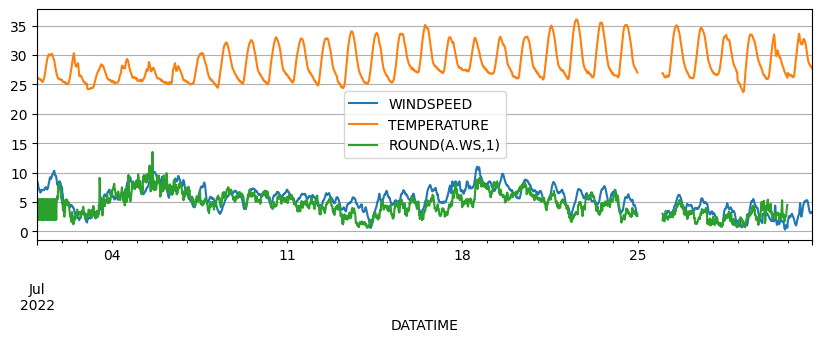

In [20]:
# 因为数据批次不同，数据集中有一些时间戳重复的脏数据，送入paddlets前要进行处理，本赛题要求保留第一个数据
df.drop_duplicates(subset = ['DATATIME'],keep='first',inplace=True)

# 我们选取最后30天的风机工况数据进行可视化
target_cov_dataset = TSDataset.load_from_dataframe(
    df[-4*24*30:],
    time_col='DATATIME',
    target_cols='YD15',
    observed_cov_cols=['WINDSPEED', 'PREPOWER', 'WINDDIRECTION', 'TEMPERATURE',
       'HUMIDITY', 'PRESSURE', 'ROUND(A.WS,1)', 'ROUND(A.POWER,0)'],
    freq='15min',
    fill_missing_dates=False
)
# 由于不同指标的数值差异较大，在绘图时选取数值范围相近的组合分开绘制可视化图表
target_cov_dataset.plot(['WINDSPEED', 'TEMPERATURE', 'ROUND(A.WS,1)'])

<AxesSubplot:xlabel='DATATIME'>

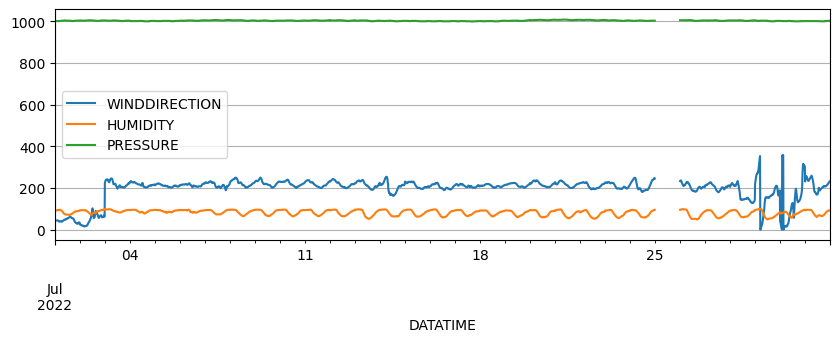

In [21]:
target_cov_dataset.plot(['WINDDIRECTION', 'HUMIDITY', 'PRESSURE'])

<AxesSubplot:xlabel='DATATIME'>

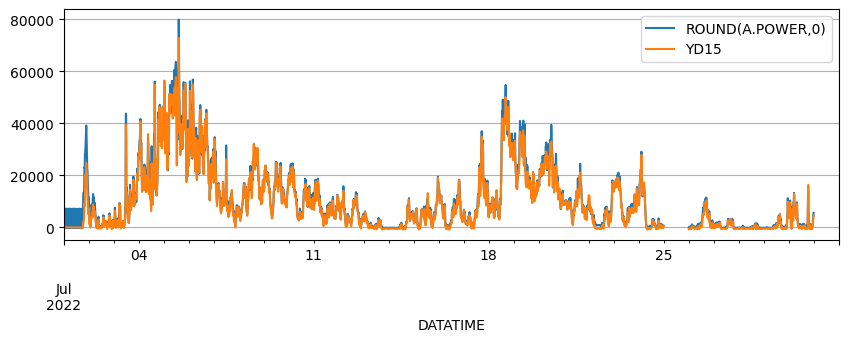

In [23]:
target_cov_dataset.plot(['ROUND(A.POWER,0)','YD15'])

<AxesSubplot:xlabel='DATATIME'>

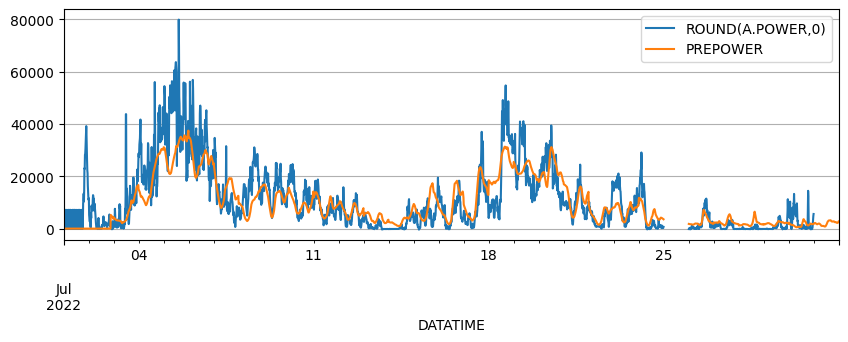

In [26]:
target_cov_dataset.plot(['ROUND(A.POWER,0)', 'PREPOWER'])

In [27]:
target_cov_dataset.summary()

,YD15,WINDSPEED,PREPOWER,WINDDIRECTION,TEMPERATURE,HUMIDITY,PRESSURE,"ROUND(A.WS,1)","ROUND(A.POWER,0)"
missing,0.064180,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.064516,0.064516
count,2785.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2784.000000,2784.000000
mean,9884.635907,5.493646,9637.794653,196.832639,28.619826,81.363194,1002.892014,4.600862,10798.044181
std,11827.093087,2.054045,8863.131911,52.427642,2.842513,12.870883,1.855815,1.947160,12237.545330
min,-852.000000,0.300000,0.000000,0.000000,23.700000,49.000000,999.000000,0.600000,-383.000000
25%,440.000000,4.100000,2414.425000,200.000000,26.300000,71.000000,1002.000000,3.000000,1115.750000
50%,6010.000000,5.600000,6687.850000,210.000000,27.800000,85.000000,1003.000000,4.600000,6913.000000
75%,15034.000000,6.900000,14437.475000,222.000000,30.800000,93.000000,1004.000000,5.900000,15962.500000
max,72719.000000,11.000000,37420.500000,358.000000,36.000000,99.000000,1008.000000,13.500000,79817.000000


In [28]:
target_cov_dataset.max()

YD15                72719.0
WINDSPEED              11.0
PREPOWER            37420.5
WINDDIRECTION         358.0
TEMPERATURE            36.0
HUMIDITY               99.0
PRESSURE             1008.0
ROUND(A.WS,1)          13.5
ROUND(A.POWER,0)    79817.0
dtype: float64

[2023-04-26 20:00:40,760] [paddlets.analysis.analysis_report] [INFO] save report succcess, save at ./analysis_report.docx


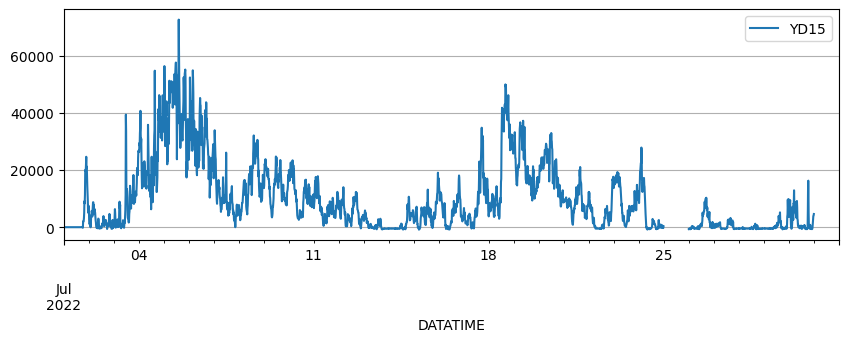

In [30]:
report = AnalysisReport(target_cov_dataset, ["summary"])
# 加入时频分析后，需要较长的计算时间
# report = AnalysisReport(target_cov_dataset, ["summary","fft","stft","cwt"])
report.export_docx_report()

# 模型应用

In [31]:
# 读取数据集

df = pd.read_csv('../../data/processed/wind-power-forecast/01.csv',parse_dates=['DATATIME'],infer_datetime_format=True,dayfirst=True,dtype={'WINDDIRECTION':np.float64, 'HUMIDITY':np.float64, 'PRESSURE':np.float64})

# 因为数据批次不同，数据集中有一些时间戳重复的脏数据，送入paddlets前要进行处理，本赛题要求保留第一个数据
df.drop_duplicates(subset = ['DATATIME'],keep='first',inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26208 entries, 0 to 34586
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATATIME          26208 non-null  datetime64[ns]
 1   WINDSPEED         26208 non-null  float64       
 2   PREPOWER          26208 non-null  float64       
 3   WINDDIRECTION     26208 non-null  float64       
 4   TEMPERATURE       26208 non-null  float64       
 5   HUMIDITY          26208 non-null  float64       
 6   PRESSURE          26208 non-null  float64       
 7   ROUND(A.WS,1)     25943 non-null  float64       
 8   ROUND(A.POWER,0)  25943 non-null  float64       
 9   YD15              26113 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 2.2 MB


In [40]:
# 数据集预处理，指定时间戳、目标值、观测值、频率，填充缺失值

target_cov_dataset = TSDataset.load_from_dataframe(
    df,
    time_col='DATATIME',
    target_cols=['ROUND(A.POWER,0)', 'YD15'],
    observed_cov_cols=['WINDSPEED', 'PREPOWER', 'WINDDIRECTION', 'TEMPERATURE',
       'HUMIDITY', 'PRESSURE', 'ROUND(A.WS,1)'],
    freq='15min',
    fill_missing_dates=True,
    fillna_method = 'pre'
)

target_cov_dataset.summary()

,"ROUND(A.POWER,0)",YD15,WINDSPEED,PREPOWER,WINDDIRECTION,TEMPERATURE,HUMIDITY,PRESSURE,"ROUND(A.WS,1)"
missing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
count,26208.000000,26208.000000,26208.000000,26208.000000,26208.000000,26208.000000,26208.000000,26208.000000,26208.000000
mean,23490.946238,23196.487408,5.236561,24145.754354,148.785485,16.875683,69.574710,1000.869696,4.884959
std,24898.709112,24935.146050,2.288975,22855.349888,88.890071,10.064448,22.073546,7.814560,2.044381
min,-487.000000,-677.000000,0.000000,61.000000,0.000000,-14.300000,5.000000,981.000000,0.000000
25%,2698.500000,2538.250000,3.600000,5930.750000,80.000000,8.900000,54.000000,995.000000,3.300000
50%,15403.000000,15081.500000,5.200000,15970.000000,132.000000,20.000000,73.000000,1000.000000,4.800000
75%,35632.000000,35177.000000,6.700000,36055.500000,216.000000,24.900000,89.000000,1007.000000,6.100000
max,96430.000000,99146.000000,16.800000,90668.000000,359.000000,35.100000,100.000000,1023.000000,21.600000


<AxesSubplot:xlabel='DATATIME'>

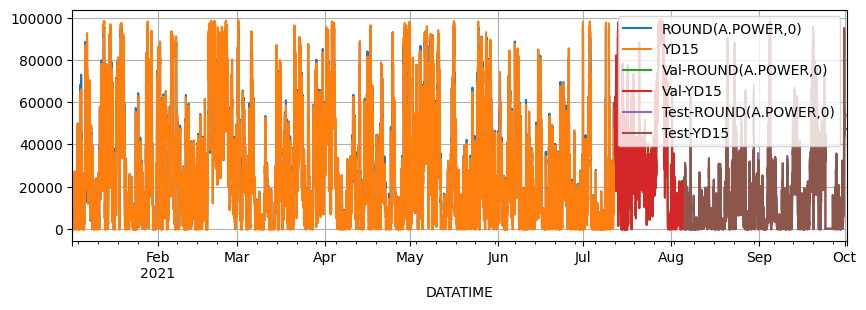

In [41]:
# 随机划分训练集、验证集、测试集，比例为70:9:21

train_dataset, val_test_dataset = target_cov_dataset.split(0.7)
val_dataset, test_dataset = val_test_dataset.split(0.3)
train_dataset.plot(add_data=[val_dataset,test_dataset], labels=['Val', 'Test'])

<AxesSubplot:xlabel='DATATIME'>

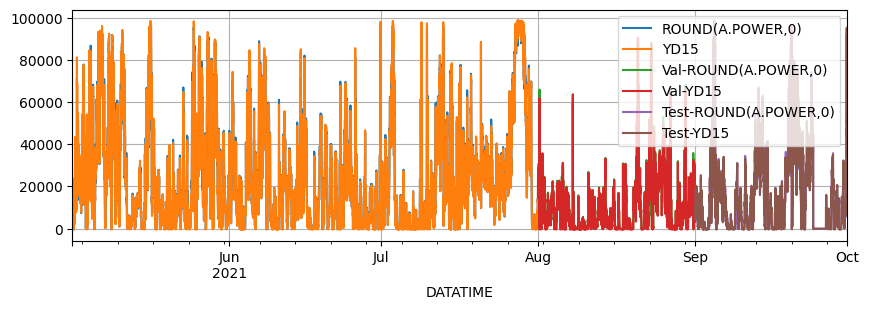

In [42]:
# 按照时间划分训练集、验证集、测试集，比例为5-7月，8月，9月

_ , train_dataset = target_cov_dataset.split('2021-05-01 00:00:00')
train_dataset, val_test_dataset = train_dataset.split('2021-08-01 00:00:00')
val_dataset, test_dataset = val_test_dataset.split('2021-09-01 00:00:00')
# 最后一天的工况数据需要预测ROUND(A.POWER,0)和YD15两个字段
test_dataset, pred_dataset = test_dataset.split('2021-10-01 00:00:00')
train_dataset.plot(add_data=[val_dataset,test_dataset], labels=['Val', 'Test'])

<AxesSubplot:xlabel='DATATIME'>

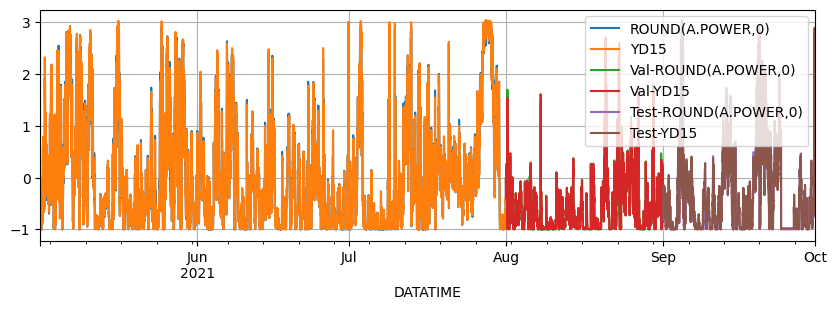

In [43]:
# 将以上数据集进行标准化处理

scaler = StandardScaler()
scaler.fit(train_dataset)
train_dataset_scaled = scaler.transform(train_dataset)
val_test_dataset_scaled = scaler.transform(val_test_dataset)
val_dataset_scaled = scaler.transform(val_dataset)
test_dataset_scaled = scaler.transform(test_dataset)

train_dataset_scaled.plot(add_data=[val_dataset_scaled,test_dataset_scaled], labels=['Val', 'Test'])

### 单模型预测

In [44]:
lstm = LSTNetRegressor(
    in_chunk_len = 4 * 24 * 5,
    out_chunk_len = 24 * 4,
    max_epochs=10,
    optimizer_params= dict(learning_rate=1e-3),
)

In [60]:
print(train_dataset.summary())
print(val_dataset.summary())

         ROUND(A.POWER,0)          YD15    WINDSPEED      PREPOWER  \
missing           0.00000      0.000000     0.000000      0.000000   
count          8832.00000   8832.000000  8832.000000   8832.000000   
mean          24381.75000  24149.419922     5.526064  23408.933594   
std           24585.34375  24663.560547     2.397271  21556.294922   
min            -487.00000   -677.000000     0.000000    231.000000   
25%            4505.75000   4314.250000     3.900000   7438.500000   
50%           17423.00000  17102.000000     5.400000  16621.000000   
75%           35509.25000  35154.500000     6.900000  31578.000000   
max           96139.00000  99041.000000    16.799999  89981.101562   

         WINDDIRECTION  TEMPERATURE     HUMIDITY     PRESSURE  ROUND(A.WS,1)  
missing       0.000000     0.000000     0.000000     0.000000       0.000000  
count      8832.000000  8832.000000  8832.000000  8832.000000    8832.000000  
mean        154.769821    24.182734    71.766075   994.247742 

In [59]:
lstm.fit(train_dataset, val_dataset)

ValueError: Input contains NaN.

In [50]:
subset_test_pred_dataset = lstm.predict(val_dataset)
subset_test_dataset, _ = test_dataset.split(len(subset_test_pred_dataset.target))

In [51]:
# 模型评估
mae = MAE()
mae(subset_test_dataset, subset_test_pred_dataset)

{'ROUND(A.POWER,0)': 7785.884078820546, 'YD15': 7743.045226097107}

<AxesSubplot:xlabel='DATATIME'>

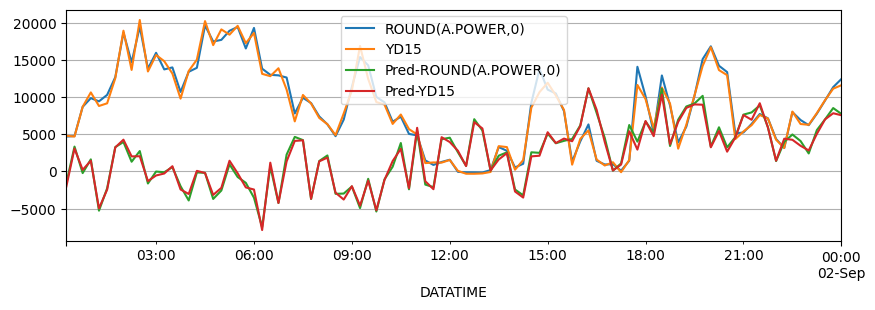

In [52]:
# 预测结果可视化
subset_test_dataset, _ = test_dataset.split(len(subset_test_pred_dataset.target))
subset_test_dataset.plot(add_data=subset_test_pred_dataset, labels=['Pred'])

In [ ]:
# 模型保存
lstm.save("lstm")

In [ ]:
# 也可以动转静保存
lstm.save("./model", network_model=True, dygraph_to_static=True)

In [ ]:
# 模型加载
from paddlets.models.model_loader import load
loaded_lstm = load("lstm")

In [ ]:
# 模型预测
result = loaded_lstm.predict(test_dataset)
result.to_dataframe()

In [ ]:
result.to_dataframe().to_csv('01.csv')

### 集成模型预测

In [61]:
from paddlets.models.forecasting import MLPRegressor
from paddlets.models.forecasting import LSTNetRegressor
from paddlets.models.forecasting import RNNBlockRegressor

lstm_params = {
    'sampling_stride': 24*4,
    'eval_metrics':["mse", "mae"],
    'batch_size': 8,
    'max_epochs': 20,
    'patience': 10
}
rnn_params = {
    'sampling_stride': 24*4,
    'eval_metrics': ["mse", "mae"],
    'batch_size': 8,
    'max_epochs': 20,
    'patience': 10
}
mlp_params = {
    'sampling_stride': 24*4,
    'eval_metrics': ["mse", "mae"],
    'batch_size': 8,
    'max_epochs': 20,
    'patience': 10,
    'use_bn': True,
}

In [62]:
from paddlets.ensemble import StackingEnsembleForecaster

reg = StackingEnsembleForecaster(
in_chunk_len= 120 * 4,
out_chunk_len= 24 * 4,
skip_chunk_len=0,
estimators=[(LSTNetRegressor, lstm_params),(RNNBlockRegressor, rnn_params), (MLPRegressor, mlp_params)])


In [63]:
# 模型拟合
reg.fit(train_dataset, val_dataset)

ValueError: Input contains NaN.

In [ ]:
subset_test_pred_dataset = reg.predict(val_dataset)
subset_test_dataset, _ = test_dataset.split(len(subset_test_pred_dataset.target))

In [ ]:
# 模型评估
mae = MAE()
mae(subset_test_dataset, subset_test_pred_dataset)

In [ ]:
subset_test_dataset, _ = test_dataset.split(len(subset_test_pred_dataset.target))
subset_test_dataset.plot(add_data=subset_test_pred_dataset, labels=['Pred'])

In [ ]:
reg.save("reg")

In [ ]:
# 集成模型加载
loaded_model0 = load("./reg/paddlets-ensemble-model0")
loaded_model1 = load("./reg/paddlets-ensemble-model1")
loaded_model2 = load("./reg/paddlets-ensemble-model2")

In [ ]:
# 输出集成模型预测结果
loaded_model0.predict(test_dataset).to_dataframe()*0.2 + loaded_model1.predict(test_dataset).to_dataframe()*0.4 + loaded_model2.predict(test_dataset).to_dataframe()*0.4

In [ ]:
# 保存集成模型预测结果
# (loaded_model0.predict(test_dataset).to_dataframe()*0.2 + loaded_model1.predict(test_dataset).to_dataframe()*0.4 + loaded_model2.predict(test_dataset).to_dataframe()*0.4).to_csv('01.csv')

### 回测

In [ ]:
from paddlets.utils import backtest
from paddlets.metrics import MAE
mae, ts_pred = backtest(data=test_dataset,
                model=lstm,
                start=0.5,  # the point after "start" as the first point
                metric=MAE(),
                return_predicts=True
                )

In [ ]:
mae

4.5 模型保存与提交说明

从赛题给的风机数据中我们可以发现，不同风机数据起始时间、预测日期均不一致。因此，选手需要逐个风机进行预测并生成提交文件。从另一个角度说，不同风机可以使用同一个时序模型、超参数，也可以使用不同的模型、超参数，选手可以自行设置。